# The task is to investigate the duration of time between the first visit to the site and the purchase of any product on the same day.

# Code:

# 1. Import the necessary libraries and load the data.


In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

auth.authenticate_user()
project_id = 'tc-da-1'

client = bigquery.Client(project=project_id)
dataset_ref = client.dataset("turing_data_analytics", project=project_id)
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))
table_id = tables[2].table_id

sql_table_id = f'{project_id}.turing_data_analytics.{table_id}'

raw_data = client.list_rows(sql_table_id).to_dataframe()

raw_data

,event_date,event_timestamp,event_name,event_value_in_usd,user_id,user_pseudo_id,user_first_touch_timestamp,category,mobile_model_name,mobile_brand_name,...,purchase_revenue_in_usd,refund_value_in_usd,shipping_value_in_usd,tax_value_in_usd,transaction_id,page_title,page_location,source,page_referrer,campaign
0,20201115,1605430896492843,user_engagement,NaN,None,13445036.7517695097,1605430699590658,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,Google Online Store,https://googlemerchandisestore.com/,google,None,<Other>
1,20201222,1608662972374077,scroll,NaN,None,78222512.5114977021,1608662850418789,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,The Google Merchandise Store - My Account,https://shop.googlemerchandisestore.com/myacco...,shop.googlemerchandisestore.com,https://shop.googlemerchandisestore.com/myacco...,(referral)
2,20210128,1611793340716086,page_view,NaN,None,19512607.6484939990,1611793336236527,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/store....,None,None,None
3,20201214,1607912184230367,user_engagement,NaN,None,71934961.8102506801,1607912180933587,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/,None,None,None
4,20201103,1604382285906806,user_engagement,NaN,None,6016153.5120427538,1600131664218605,mobile,Pixel 3,Google,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/,googlemerchandisestore.com,None,(referral)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295579,20201120,1605862764214705,scroll,NaN,None,1078345042.0353486828,1605689102248022,desktop,ChromeBook,Google,...,NaN,NaN,NaN,NaN,None,Womens | Apparel | Google Merchandise Store,https://shop.googlemerchandisestore.com/Google...,(data deleted),https://shop.googlemerchandisestore.com/Google...,(data deleted)
4295580,20201120,1605893581620475,user_engagement,NaN,None,8156646657.1507119761,1605760010496350,desktop,ChromeBook,Google,...,NaN,NaN,NaN,NaN,None,Womens | Apparel | Google Merchandise Store,https://shop.googlemerchandisestore.com/Google...,<Other>,https://shop.googlemerchandisestore.com/?,(data deleted)
4295581,20201116,1605499269854062,view_promotion,NaN,None,1472078.3811921453,1605401711049172,desktop,ChromeBook,Google,...,NaN,NaN,NaN,NaN,(not set),Home,https://shop.googlemerchandisestore.com/,None,None,None
4295582,20201125,1606276163878152,view_item,NaN,None,2495031.0023544808,1606249734168696,desktop,ChromeBook,Google,...,NaN,NaN,NaN,NaN,(not set),Bags | Lifestyle | Google Merchandise Store,https://shop.googlemerchandisestore.com/Google...,None,None,None


# 2. Next, we need to apply a few filters:

# * We need the customer's first event timestamp.
# * We need the customer's purchase event timestamp.

# Additionally, we need the 'Category,' 'Mobile brand name,' and 'Browser' columns for deeper investigation.

# Next, we join these two tables to create a table with customer purchase and first visit information.

# The timestamps seem to be presented in Epoch format, so we convert them to human-readable format.

# Lastly, we calculate the total number of minutes spent before a purchase. Since we are only interested in same-day purchases, we use a < 1440 min filter (1 day).



In [ ]:
filtered_data_for_first_event = raw_data['event_name'] == 'first_visit'
filtered_data_for_purchase_date = raw_data['event_name'] == 'purchase'

first_visit = raw_data.loc[filtered_data_for_first_event, ['user_pseudo_id', 'event_timestamp']]
purchase_date = raw_data.loc[filtered_data_for_purchase_date, ['user_pseudo_id', 'event_timestamp', 'category', 'mobile_brand_name', 'browser']]

joined_data = purchase_date.merge(first_visit, how='inner', on='user_pseudo_id', suffixes=('_purchase', '_first_visit'))

joined_data['event_timestamp_purchase'] = pd.to_datetime(joined_data['event_timestamp_purchase'], unit='us')
joined_data['event_timestamp_first_visit'] = pd.to_datetime(joined_data['event_timestamp_first_visit'], unit='us')

joined_data['time_spent'] = (joined_data['event_timestamp_purchase'] - joined_data['event_timestamp_first_visit']).dt.total_seconds()
joined_data['time_spent'] = round((joined_data['time_spent'] / 60), 2)

joined_data = joined_data[(0 < joined_data['time_spent']) & (joined_data['time_spent'] < 1440)]

joined_data

,user_pseudo_id,event_timestamp_purchase,category,mobile_brand_name,browser,event_timestamp_first_visit,time_spent
0,67357054.9566811359,2020-12-04 08:23:21.320109,desktop,Microsoft,Edge,2020-12-04 07:45:37.521491,37.73
2,5823061.9157756741,2020-11-11 09:13:57.366029,desktop,Microsoft,Edge,2020-11-11 09:00:04.149405,13.89
3,9584008.2004173620,2020-12-11 22:46:14.698618,desktop,Google,Chrome,2020-12-11 22:37:01.784866,9.22
4,67425241.5630895543,2020-11-27 08:58:43.924991,desktop,Google,Chrome,2020-11-27 08:33:37.682568,25.10
5,65189665.2053976806,2021-01-08 12:04:46.907145,desktop,Google,Chrome,2021-01-08 11:56:38.876816,8.13
...,...,...,...,...,...,...,...
4432,3393889.7396147285,2020-12-09 22:46:40.956497,mobile,Samsung,<Other>,2020-12-09 21:09:35.527052,97.09
4434,3830673.4752434108,2020-12-31 14:33:40.509724,tablet,<Other>,<Other>,2020-12-31 13:54:02.924610,39.63
4437,55607257.5767935321,2021-01-19 09:39:08.166089,desktop,Google,Chrome,2021-01-19 06:07:04.758966,212.06
4440,6907870.6816785534,2021-01-24 08:17:49.087263,desktop,Google,Chrome,2021-01-24 03:01:13.664251,316.59


# 3. We convert the timestamps to date format and aggregate the data for each day to calculate the average time spent on the site.

In [ ]:
joined_data['event_timestamp_first_visit'] = pd.to_datetime(joined_data['event_timestamp_first_visit']).dt.date

average_time_spent_by_day = joined_data.groupby('event_timestamp_first_visit')['time_spent'].agg(['mean','median', 'count']).reset_index()

average_time_spent_by_day

,event_timestamp_first_visit,mean,median,count
0,2020-11-01,139.689000,19.575,10
1,2020-11-02,204.179444,14.380,18
2,2020-11-03,157.316538,25.525,26
3,2020-11-04,96.283889,93.395,18
4,2020-11-05,153.720000,22.930,11
...,...,...,...,...
87,2021-01-27,194.663200,18.600,25
88,2021-01-28,222.827273,19.790,22
89,2021-01-29,49.819259,14.620,27
90,2021-01-30,19.168750,20.985,8


# 4. We plot the results on a line plot and calculate the average time spent on the site before making a purchase.

The median time spent per day before making a purchase is 24.12 minutes 

The average time spent per day before making a purchase is 145.05 minutes 



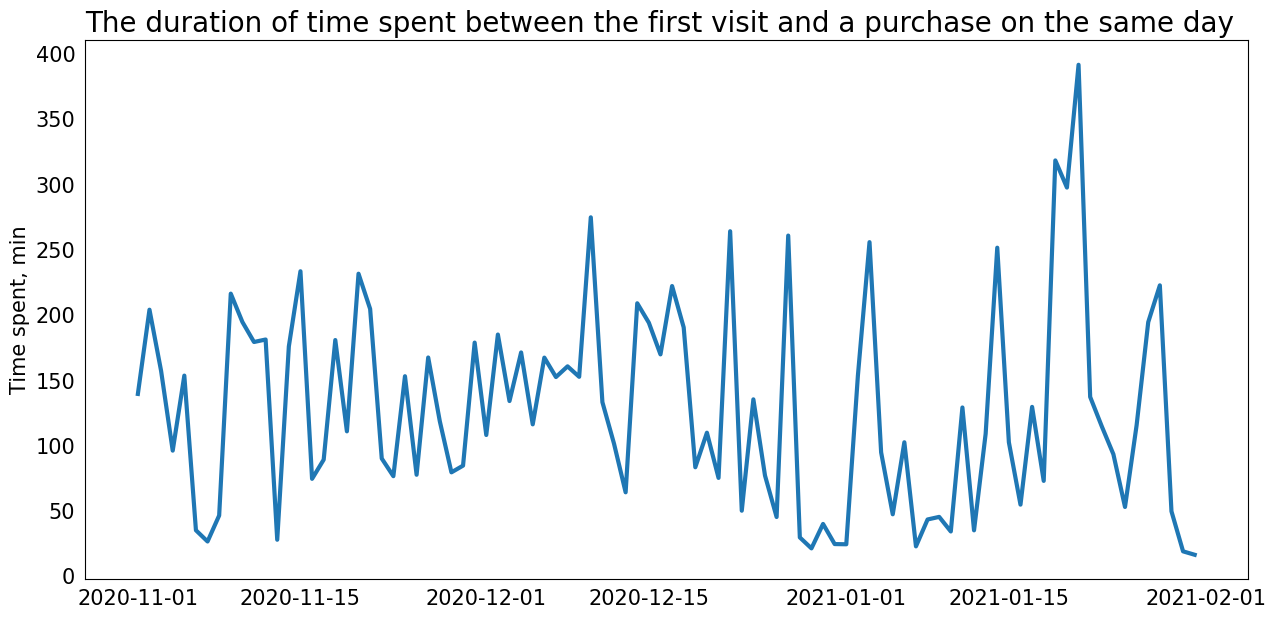

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

sns.lineplot(data=average_time_spent_by_day, x='event_timestamp_first_visit', y='mean', linewidth=3)

plt.title('The duration of time spent between the first visit and a purchase on the same day', loc='left', size=20)
plt.xlabel('')
plt.ylabel('Time spent, min', size=15)
plt.tick_params(labelsize=15, left=False, bottom=False)

median_time = round(joined_data['time_spent'].median(), 2)
average_time = round(joined_data['time_spent'].mean(), 2)

print('The median time spent per day before making a purchase is', median_time,'minutes','\n')
print('The average time spent per day before making a purchase is', average_time,'minutes','\n')

# 5. We investigate the same 'problem', but now let us divide the experience by the devices customers use.

  category        mean  median  count  percentage_of_total
2   tablet   87.566809  17.120     47                 1.72
1   mobile  143.663699  24.340   1149                42.03
0  desktop  147.841021  24.145   1538                56.25 



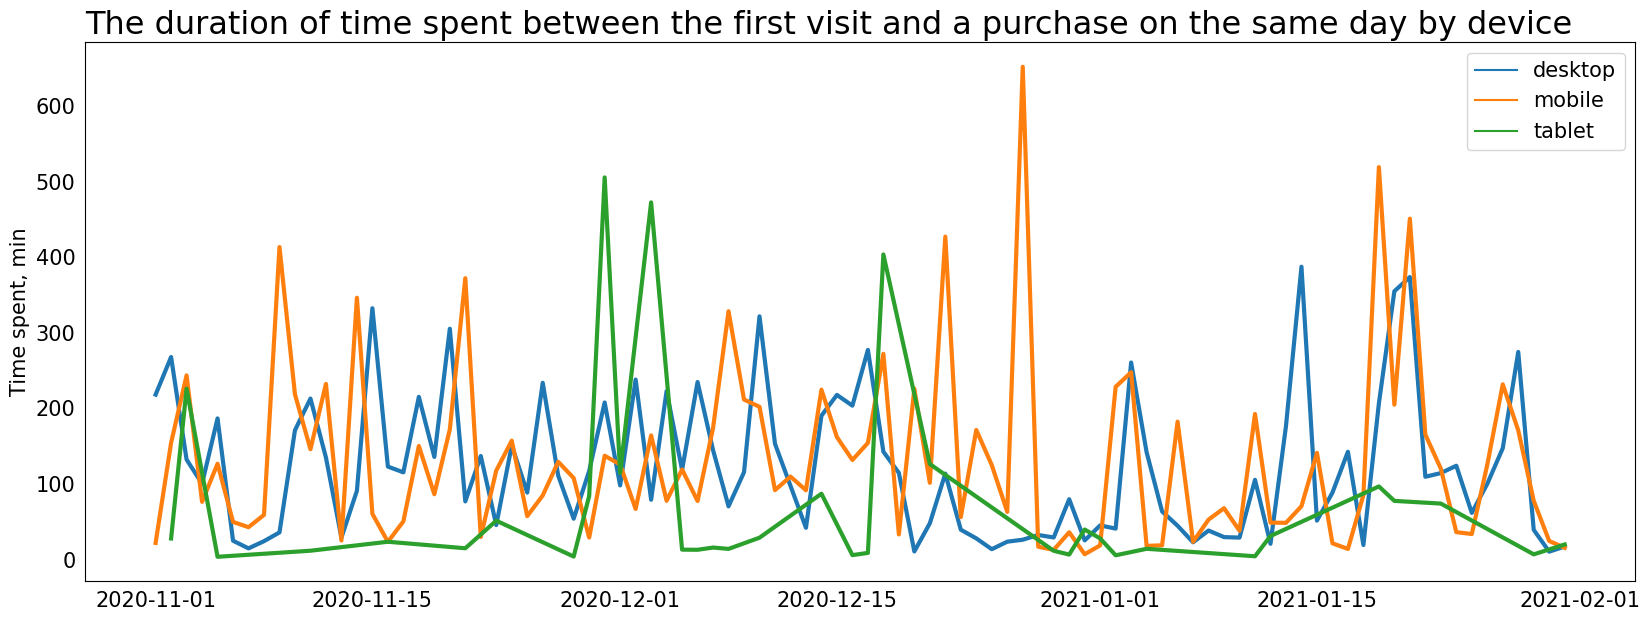

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=joined_data, x='event_timestamp_first_visit', y='time_spent', hue='category', errorbar=None, linewidth=3)

plt.title('The duration of time spent between the first visit and a purchase on the same day by device', loc='left', size=23)
plt.xlabel('')
plt.ylabel('Time spent, min', size=15)
plt.tick_params(labelsize=15, left=False, bottom=False)
plt.legend(title='', fontsize=15)

average_time = joined_data.groupby('category')['time_spent'].agg(['mean','median', 'count']).reset_index()
average_time['percentage_of_total'] = round((average_time['count'] / average_time['count'].sum()) * 100, 2)
average_time = average_time.sort_values(by='mean')

print(average_time, '\n')


#6. We investigate the same 'problem' but, this time, we divide the experience by the brand of the device.

  mobile_brand_name        mean  median  count  percentage_of_total
2            Huawei   56.208163  16.690     49                 1.95
5            Xiaomi  100.119492  20.140     59                 2.35
3         Microsoft  101.963611  20.655     36                 1.44
1            Google  125.356119  23.770    938                37.42
0             Apple  155.355518  24.810   1216                48.50
4           Samsung  191.939091  27.140    209                 8.34 



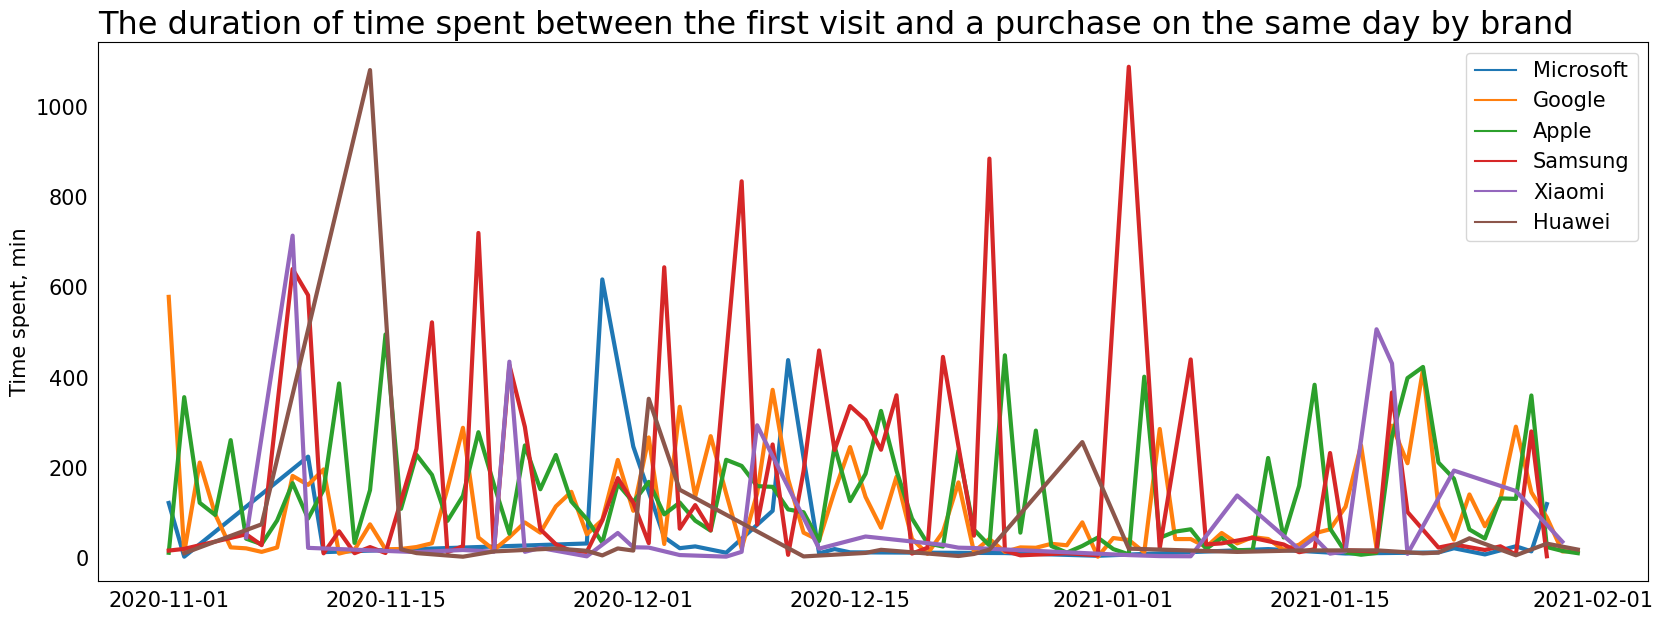

In [ ]:
filtered = joined_data[(joined_data['mobile_brand_name'] != '<Other>') & (joined_data['mobile_brand_name'] != 'Mozilla')]
plt.figure(figsize=(20, 7))
sns.lineplot(data=filtered, x='event_timestamp_first_visit', y='time_spent', hue='mobile_brand_name', errorbar=None, linewidth=3)

plt.title('The duration of time spent between the first visit and a purchase on the same day by brand', loc='left', size=23)
plt.xlabel('')
plt.ylabel('Time spent, min', size=15)
plt.tick_params(labelsize=15, left=False, bottom=False)
plt.legend(title='', fontsize=15)

average_time = filtered.groupby('mobile_brand_name')['time_spent'].agg(['mean','median', 'count']).reset_index()
average_time['percentage_of_total'] = round((average_time['count'] / average_time['count'].sum()) * 100, 2)
average_time = average_time.sort_values(by='mean')

print(average_time, '\n')


# 7. Lastly, we investigate the same 'problem,' but this time, we divide the experience by the browser they are using.

   browser        mean  median  count  percentage_of_total
1     Edge  103.244545   16.75     33                 1.26
2  Firefox  117.386757   18.89     37                 1.41
3   Safari  127.954489   24.42    695                26.49
0   Chrome  149.153459   23.86   1859                70.85 



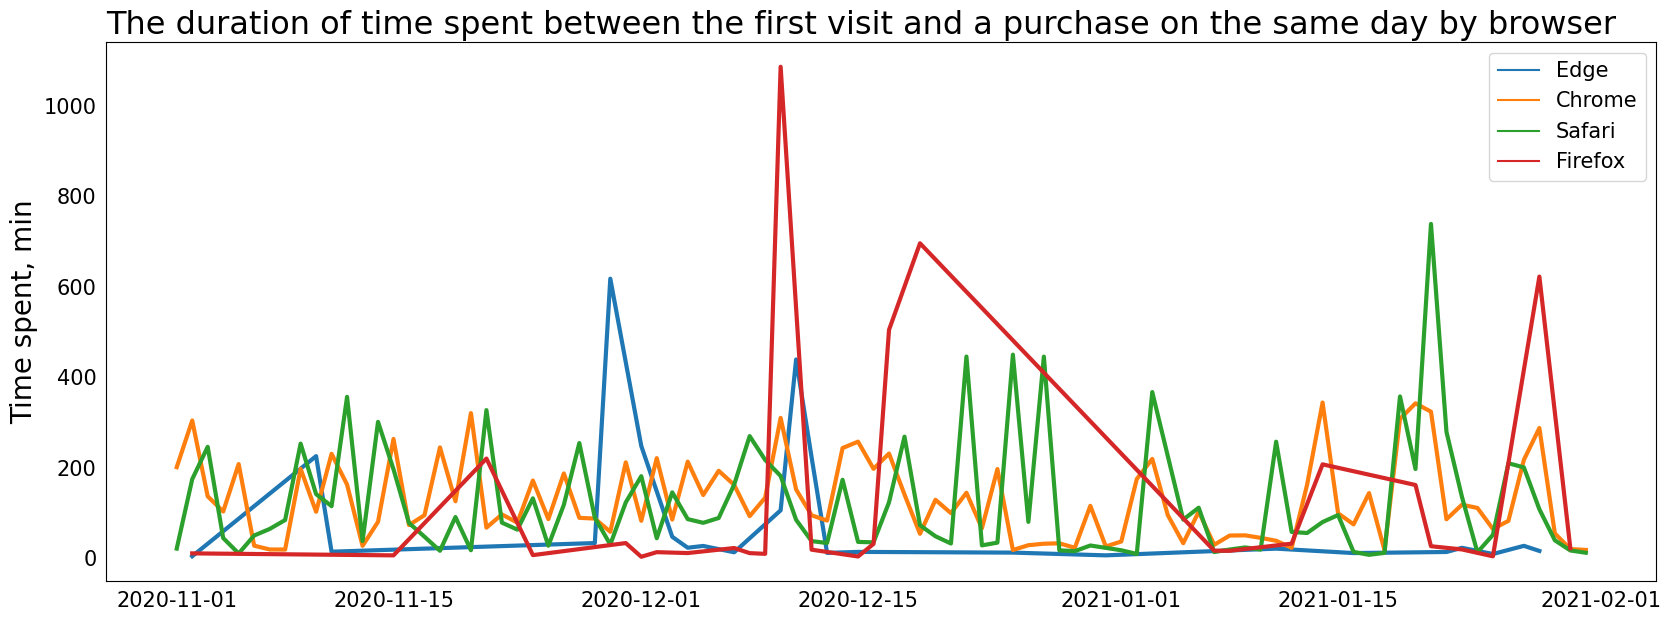

In [ ]:
filtered_data = joined_data[(joined_data['browser'] != '<Other>') & (joined_data['browser'] != 'Android Webview')]

plt.figure(figsize=(20, 7))

sns.lineplot(data=filtered_data, x='event_timestamp_first_visit', y='time_spent', hue='browser', errorbar=None, linewidth=3)

plt.title('The duration of time spent between the first visit and a purchase on the same day by browser', loc='left', size=23)
plt.xlabel('')
plt.ylabel('Time spent, min', size=20)
plt.tick_params(labelsize=15, left=False, bottom=False)
plt.legend(title='', fontsize=15)

average_time = filtered_data.groupby('browser')['time_spent'].agg(['mean','median', 'count']).reset_index()
average_time['percentage_of_total'] = round((average_time['count'] / average_time['count'].sum()) * 100, 2)
average_time = average_time.sort_values(by='mean')

print(average_time, '\n')


# Conclusions:

# 1. On average, people spend approximately 2.5 hours on the site before making their first purchase.

# 2. Interestingly, tablet users tend to make purchases around 2 times faster than desktop or phone users. It's important to note that the total number of tablet users is small, and the average time spent on the site may increase with more data coming in. This is because there is no significant difference between desktop and mobile users.

# 3. Huawei, Xiaomi, Microsoft, and Google device users make purchases more quickly. However, Apple and Samsung users tend to experience a longer path on average. It's worth to notice that Huawei, Xiaomi, Samsung, and Google users utilize the Android OS. With more data coming in, we can expect the average time (of Huawei, Xiaomi and Samsung users) to shift towards Google data since Google users make up to 37% of this analysis. Additionally, when comparing Android vs iOS systems, we observe that iOS users experience a path that is 30+ minutes longer than Android users.

# 4. Lastly, we observe that Edge, Firefox, and Safari users tend to make purchases more quickly than Chrome users. However, Chrome users constitute the majority of the analysis; thus, data from other browsers has the potential to increase.

# 5. Nevertheless, there is really no detectable or significant difference in the usage of different devices, browsers, or brands. The major differences observed in the analysis can be attributed to a small data range and highly unbalanced data.